# Проект "Промышленность"

## Задача

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.  
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).  
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.  
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Импорты и константы

In [88]:
%matplotlib inline
import datetime as dt
import os.path as p
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, make_scorer

from lightgbm.sklearn import LGBMRegressor

RANDOM_STATE = 130323
DATA_DIR_LOCAL = 'final_steel'
DATA_DIR_YANDEX = '/datasets/final_steel'

## Загрузка и первичная проверка данных

### Данные об электродах

In [89]:
try:
    data_arc = pd.read_csv(p.join(DATA_DIR_LOCAL, 'data_arc.csv'))
except FileNotFoundError:
    data_arc = pd.read_csv(p.join(DATA_DIR_YANDEX, 'data_arc.csv'))
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Посмотрим на первые строки:

In [90]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Явных пропусков нет. Тип данных распознан наполовину правильно. Время лучше преобразовать к timestamp. Неплохо бы так же добавить столбец с длительностью нагрева. Для удобства можно переименовать столбцы. Проверим на полные дубликаты:

In [91]:
data_arc.duplicated().sum()

0

In [92]:
ren_cols = {'Начало нагрева дугой': 'arc_start', 
            'Конец нагрева дугой':'arc_end', 
            'Активная мощность':'p_active',
            'Реактивная мощность':'p_reactive'}
data_arc = data_arc.rename(columns=ren_cols)
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         14876 non-null  int64  
 1   arc_start   14876 non-null  object 
 2   arc_end     14876 non-null  object 
 3   p_active    14876 non-null  float64
 4   p_reactive  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [93]:
data_arc['arc_start'] = pd.to_datetime(data_arc['arc_start'])
data_arc['arc_end'] = pd.to_datetime(data_arc['arc_end'])
data_arc['arc_time'] = data_arc['arc_end'] - data_arc['arc_start']
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   key         14876 non-null  int64          
 1   arc_start   14876 non-null  datetime64[ns] 
 2   arc_end     14876 non-null  datetime64[ns] 
 3   p_active    14876 non-null  float64        
 4   p_reactive  14876 non-null  float64        
 5   arc_time    14876 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), timedelta64[ns](1)
memory usage: 697.4 KB


In [94]:
data_arc.head()

,key,arc_start,arc_end,p_active,p_reactive,arc_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0 days 00:02:28


Операции с данными проведены. Анализ переменных и поиск аномалий проведём в следубщей части.

### Данные о подаче сыпучих материалов (объём)

In [95]:
try:
    data_bulk = pd.read_csv(p.join(DATA_DIR_LOCAL, 'data_bulk.csv'))
except FileNotFoundError:
    data_bulk = pd.read_csv(p.join(DATA_DIR_YANDEX, 'data_bulk.csv'))
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [96]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Типы данных распознаны успешно. Пропусков много, однако это обусловлено тем, что по видимому пропуски обозначают, что легирующая добавка не была добавлена. Скорее всего это значение можно заполнить нулём, но при этом не совсем показательна будет описательная статистика. Посчитаем её заранее.

In [97]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Выраженных аномалий нет. Преобразуем NaN к 0.0

In [98]:
data_bulk_nna = data_bulk.fillna(0.0)
data_bulk_nna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Преобразование выполнено успешно.

### Данные о подаче сыпучих материалов (время)

In [99]:
try:
    data_bulk_time = pd.read_csv(p.join(DATA_DIR_LOCAL, 'data_bulk_time.csv'))
except FileNotFoundError:
    data_bulk_time = pd.read_csv(p.join(DATA_DIR_YANDEX, 'data_bulk_time.csv'))
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [100]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Типы данных хорошо бы преобразовать в timestamp. Пропуски обозначают, что данные легирующие добавки не добавлялись. Они соответствуют пропускам в предыдущей таблице. Заполнять их в этой таблице дума. не стоит.

In [101]:
data_bulk_time.iloc[:, 1:] = data_bulk_time.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


<ipython-input-101-1916e3201a58>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_bulk_time.iloc[:, 1:] = data_bulk_time.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')


In [102]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


Типы успешно сконвертированы.

### Данные о проволочных материалах (объём)

In [103]:
try:
    data_wire = pd.read_csv(p.join(DATA_DIR_LOCAL, 'data_wire.csv'))
except FileNotFoundError:
    data_wire = pd.read_csv(p.join(DATA_DIR_YANDEX, 'data_wire.csv'))
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [104]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Результаты аналогичны результатам для сыпучих материалов.

In [106]:
data_wire_nna = data_wire.fillna(0.0)
data_wire_nna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


### Данные о проволочных материалах (время).

In [107]:
try:
    data_wire_time = pd.read_csv(p.join(DATA_DIR_LOCAL, 'data_wire_time.csv'))
except FileNotFoundError:
    data_wire_time = pd.read_csv(p.join(DATA_DIR_YANDEX, 'data_wire_time.csv'))
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [108]:
data_bulk_time.iloc[:, 1:] = data_bulk_time.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


<ipython-input-108-1916e3201a58>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_bulk_time.iloc[:, 1:] = data_bulk_time.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')


### Данные о продувке сплава газом

In [109]:
try:
    data_gas = pd.read_csv(p.join(DATA_DIR_LOCAL, 'data_gas.csv'))
except FileNotFoundError:
    data_gas = pd.read_csv(p.join(DATA_DIR_YANDEX, 'data_gas.csv'))
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [110]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Явных пропусков нет. Типы данных определены верно. Единственное: стоит для удобства переименовать столбец.

In [111]:
ren_cols = {'Газ 1': 'gas'}
data_gas = data_gas.rename(columns=ren_cols)
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


### Результаты измерения температуры

In [112]:
try:
    data_temp = pd.read_csv(p.join(DATA_DIR_LOCAL, 'data_temp.csv'))
except FileNotFoundError:
    data_temp = pd.read_csv(p.join(DATA_DIR_YANDEX, 'data_temp.csv'))
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [113]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Думаю что следует преобразовать Время замера в datetime и переименовать столбцы для удобства работы. Следует так же очистить датасет от пропусков в температуре - так как это во первых ключевой показатель, во-вторых конечная температура является таргетом. Промежуточную температуры следует удалить может следует переформатировать таблицу оставив только конечную и начальную температуру для каждого key.

In [114]:
data_temp = data_temp.dropna()
ren_cols = {'Время замера': 't_time', "Температура":"T"}
data_temp = data_temp.rename(columns=ren_cols)
data_temp.t_time = pd.to_datetime(data_temp.t_time)
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     13006 non-null  int64         
 1   t_time  13006 non-null  datetime64[ns]
 2   T       13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.4 KB


## Исследование  переменных, поиск аномалий и корреляций

### Данные об электродах

In [115]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   key         14876 non-null  int64          
 1   arc_start   14876 non-null  datetime64[ns] 
 2   arc_end     14876 non-null  datetime64[ns] 
 3   p_active    14876 non-null  float64        
 4   p_reactive  14876 non-null  float64        
 5   arc_time    14876 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), timedelta64[ns](1)
memory usage: 697.4 KB


#### Ключ

In [116]:
data_arc.key.nunique()

3214

Процесс многостадийный поэтому уникальных ключей меньше, чем всего строк. Подсчитаем сколько стадий нагрева в выборке.

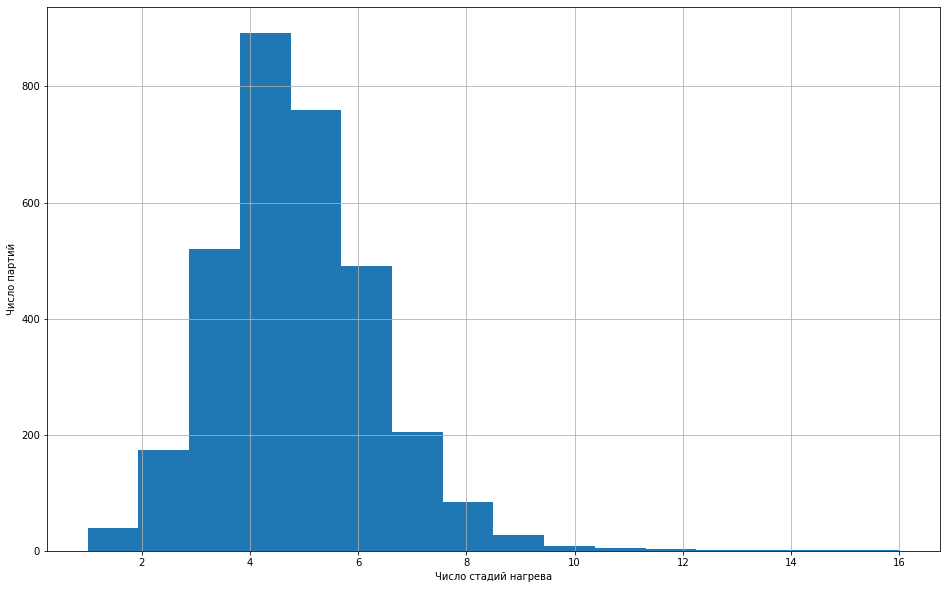

In [117]:
ax = data_arc.key.value_counts().hist(figsize=(16,10), bins=16);
ax.set_xlabel("Число стадий нагрева");
ax.set_ylabel("Число партий");

In [118]:
data_arc.key.value_counts().describe()

count    3214.000000
mean        4.628500
std         1.608647
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: key, dtype: float64

В среднем 4 нагрева. Есть те где один нагрев.

#### Активная мощность

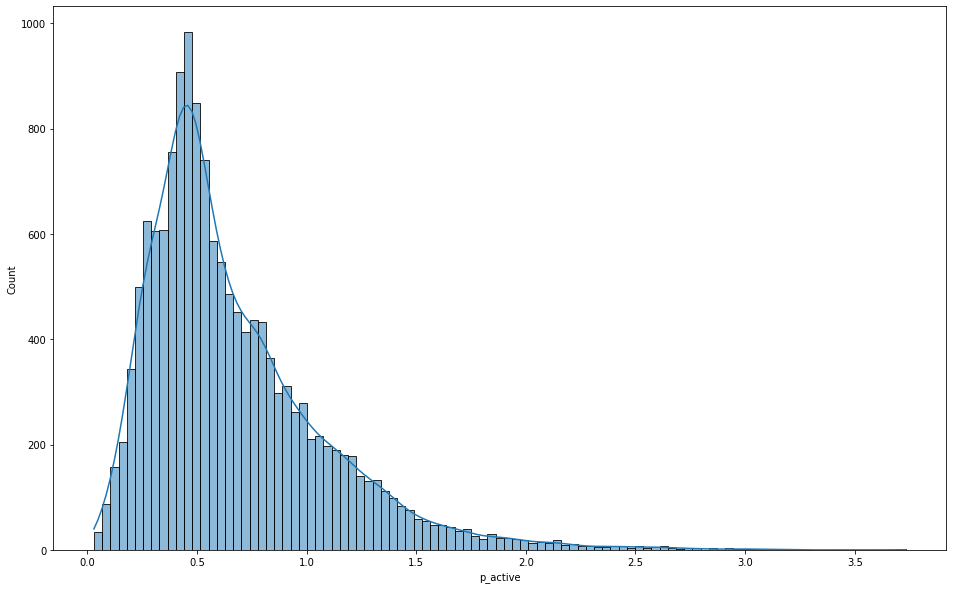

In [119]:
plt.figure(figsize=(16,10))
sns.histplot(data_arc['p_active'], kde=True);

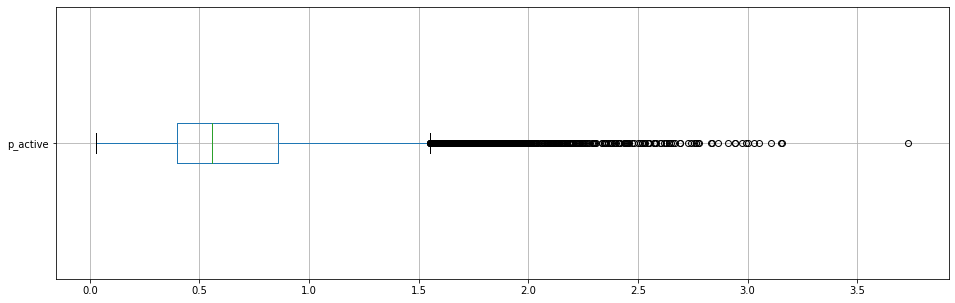

In [120]:
data_arc.boxplot('p_active', vert=False, figsize=(16, 5));

Особенно выбивается одно значение, однако оно находится в целом в разумных пределах. Если мы имеем дело с тугоплавкими сталями может и следует включать электроды на такую мощность.

#### Рективная мощность

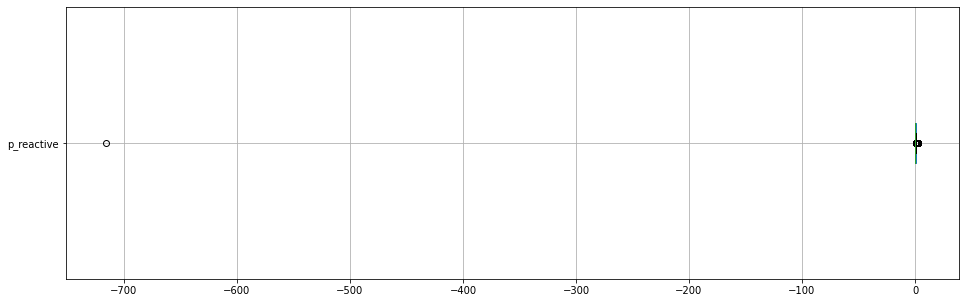

In [121]:
data_arc.boxplot('p_reactive', vert=False, figsize=(16, 5));

Одна точка с высокой отрицательной мощностью явный сбой. Удаляем.

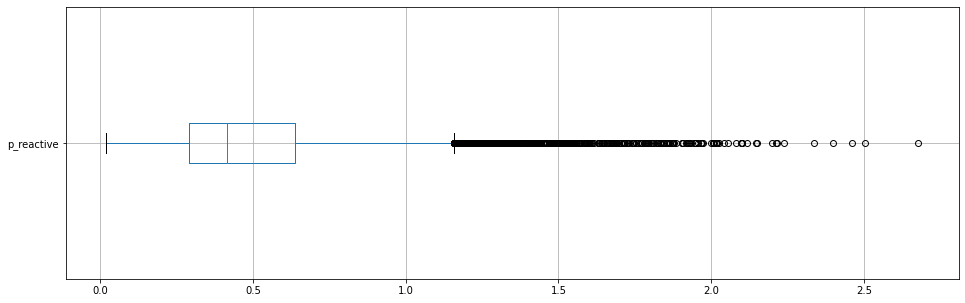

In [122]:
data_arc = data_arc.query('p_reactive >= 0.0')
data_arc.boxplot('p_reactive', vert=False, figsize=(16, 5));

Тоже что и для активной мощности.

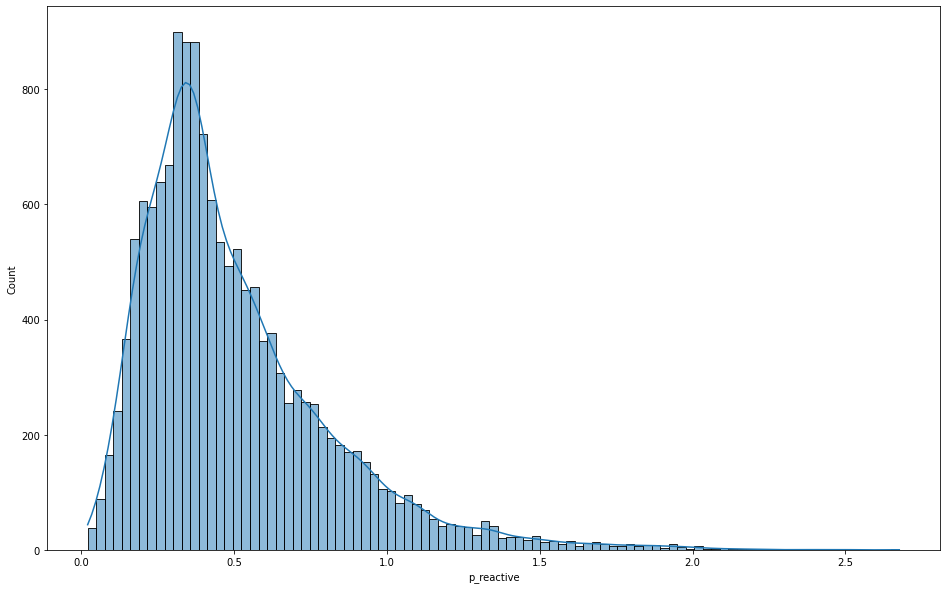

In [123]:
plt.figure(figsize=(16,10))
sns.histplot(data_arc['p_reactive'], kde=True);

#### Активная vs. Реактивная

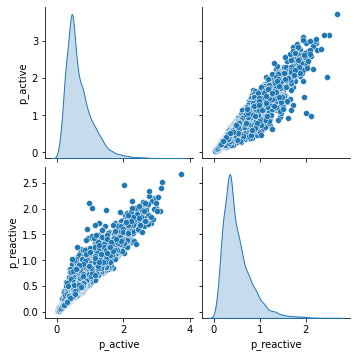

In [124]:
sns.pairplot(data_arc[['p_active', 'p_reactive']], diag_kind='kde');

In [125]:
data_arc['p_active'].corr(data_arc['p_reactive'], method='spearman')

0.9694408472607176

Связь между переменными прямая и очень сильная. Один и тот же и cos(phi).

### Данные о подаче сыпучих материралов (объём)

In [126]:
data_bulk.key.nunique()

3129

Количество строчек совпадает с количеством уникальных ключей. Определим самые популярные и наименее популярные добавки.

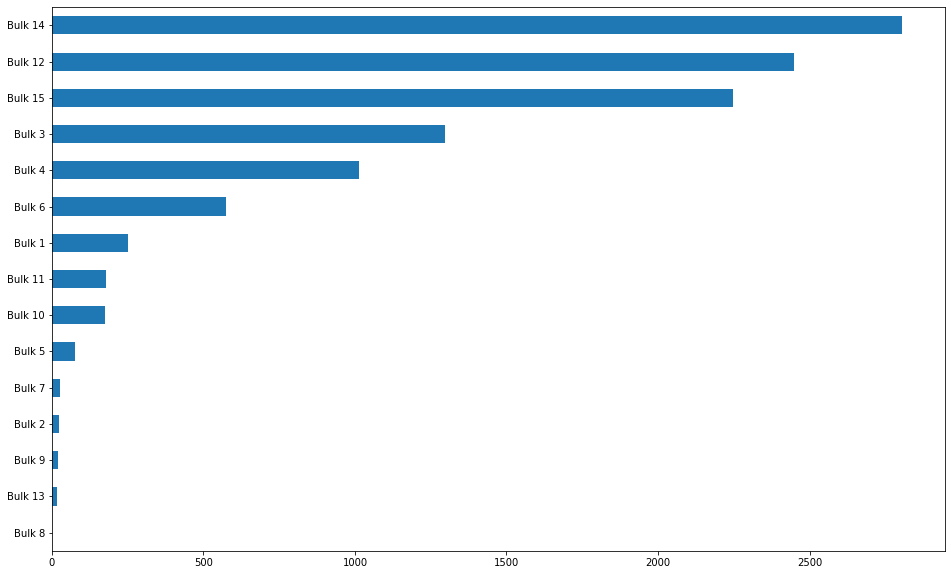

In [127]:
data_bulk.iloc[:,1:].notna().sum().sort_values().plot(kind='barh', figsize=(16, 10));

Есть совсем редкие добавки, стоит видимо их исключить из признаков.

Постоим boxplot.

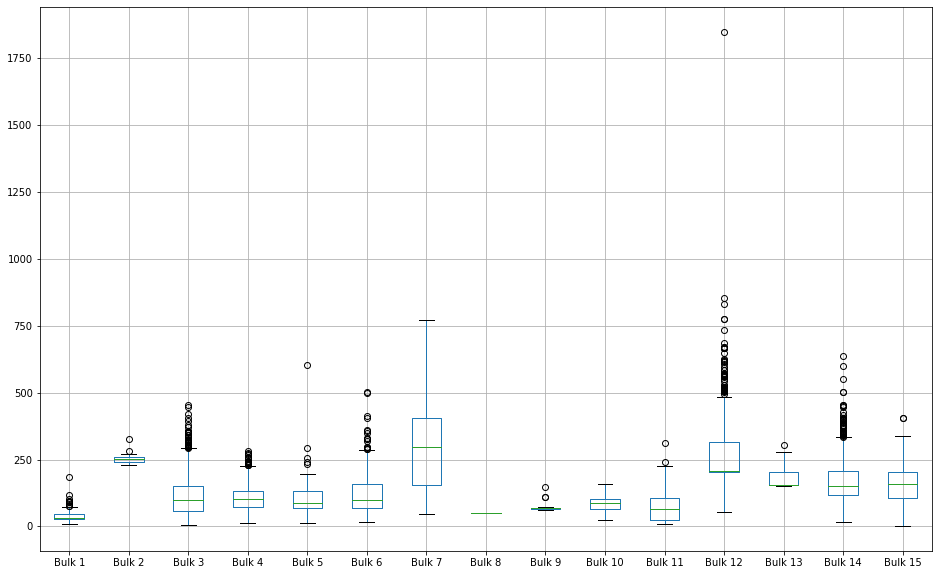

In [128]:
data_bulk.iloc[:, 1:].boxplot(figsize=(16,10));

По некоторым добавкам есть очень большие выбросы (напр. 12), думаю стоит исключить их из данных для обучения модели.

### Данные о подаче проволочных материралов (объём)
Проведём тоже исследование, что и для сыпучих.

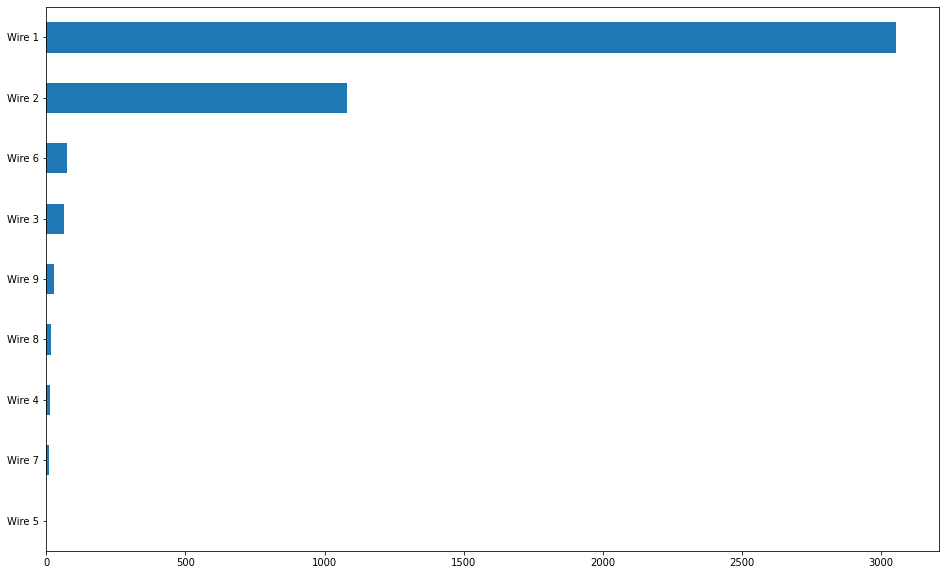

In [129]:
data_wire.iloc[:,1:].notna().sum().sort_values().plot(kind='barh', figsize=(16, 10));

Всего две популярные проволочные добавки. Остальные видимо можно исключить из признаков.

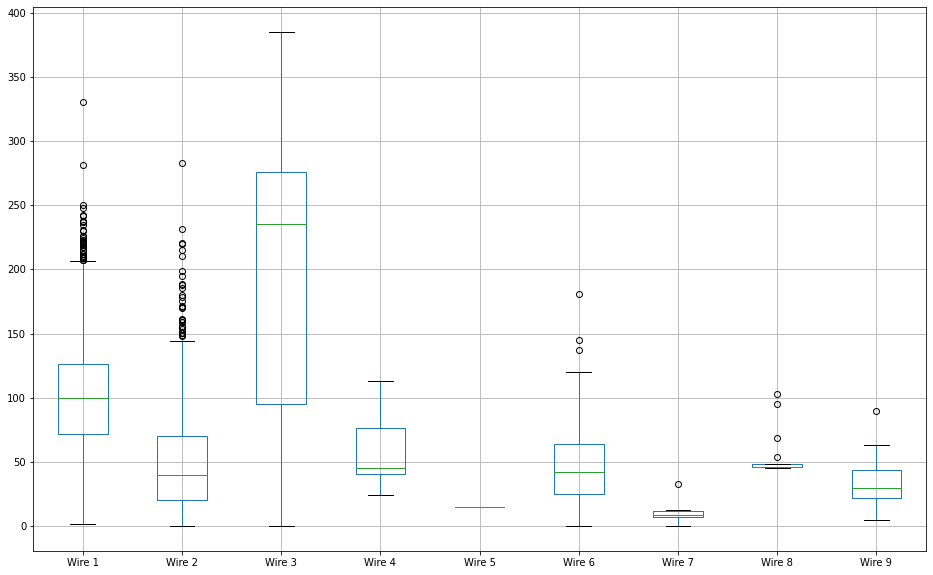

In [130]:
data_wire.iloc[:, 1:].boxplot(figsize=(16,10));

Выбросы тоже присутствуют, но совсем уж выпадающих точек практически нет.

### Продувка газом

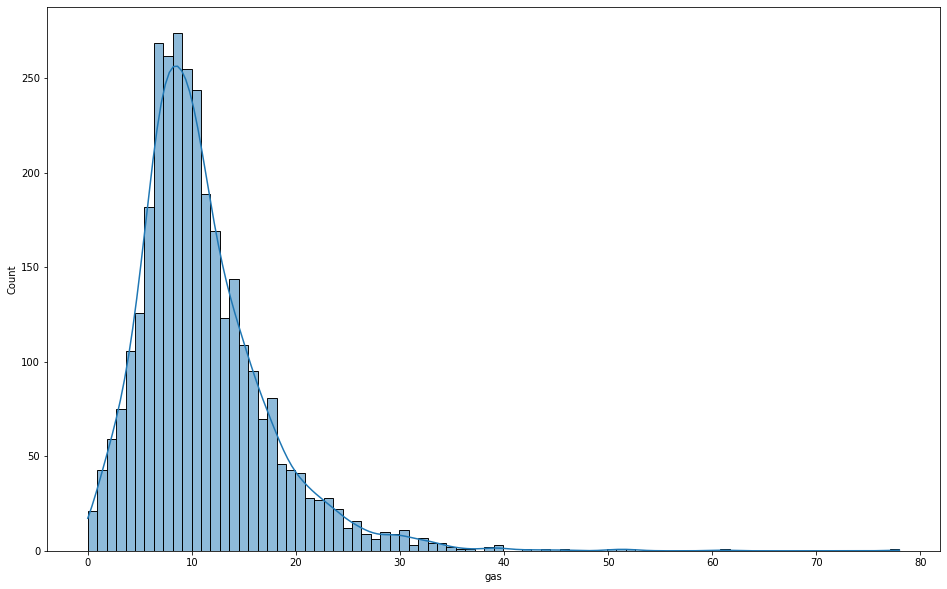

In [131]:
plt.figure(figsize=(16,10))
sns.histplot(data_gas['gas'], kde=True);

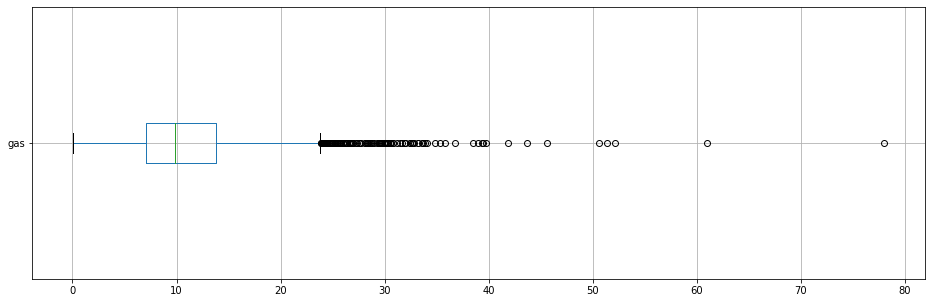

In [132]:
data_gas.boxplot('gas', vert=False, figsize=(16, 5));

Несколько значений совсем выпадают, имеет смысл их исключить, по крайней мере на тренировочном наборе.

### Данные о температуре

#### key

In [133]:
data_temp.key.nunique()

3216

Для образцов было несколько измерений температуры, поэтому уникальных ключей меньше, чем всего строк. Подсчитаем сколько измерений температуры в выборке.

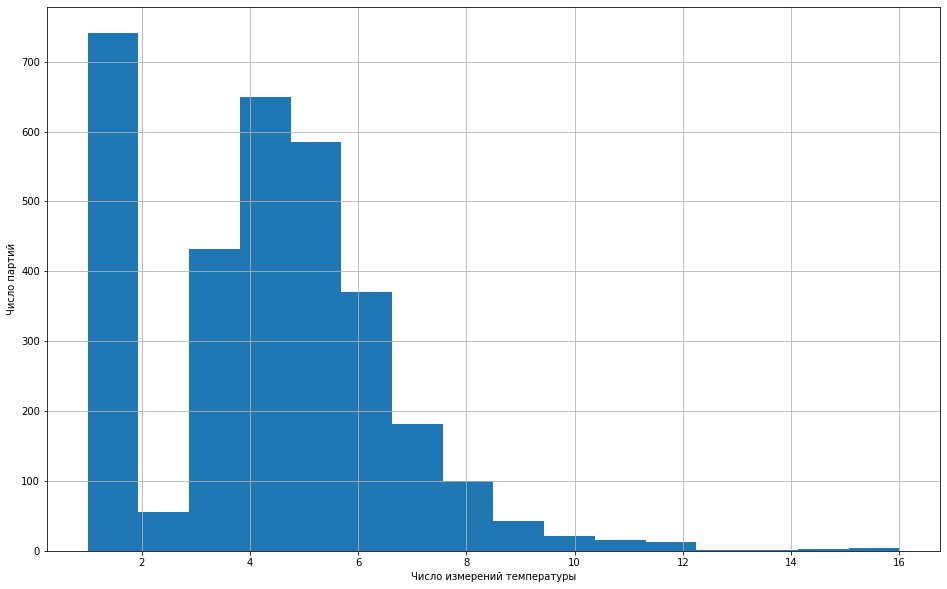

In [134]:
ax = data_temp.key.value_counts().hist(figsize=(16,10), bins=16);
ax.set_xlabel("Число измерений температуры");
ax.set_ylabel("Число партий");

In [135]:
data_temp.key.value_counts().describe()

count    3216.000000
mean        4.044154
std         2.299755
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        16.000000
Name: key, dtype: float64

В среднем 4 измерения температуры это соответствует в обшем среднему числу включений дуги. Есть, те где одно измерение и такие строки должны быть удалены, по требованию заказчика.

#### Температура

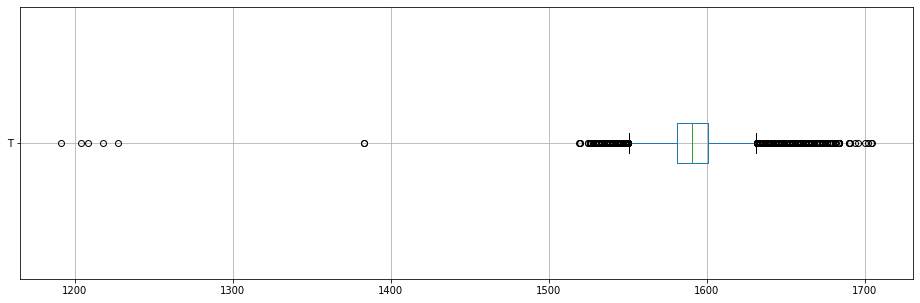

In [136]:
data_temp.boxplot('T', vert=False, figsize=(16, 5));

Температура менее 1400 врят ли имеет место быть - это аномалии.

In [137]:
data_temp = data_temp[data_temp['T'] > 1400] 

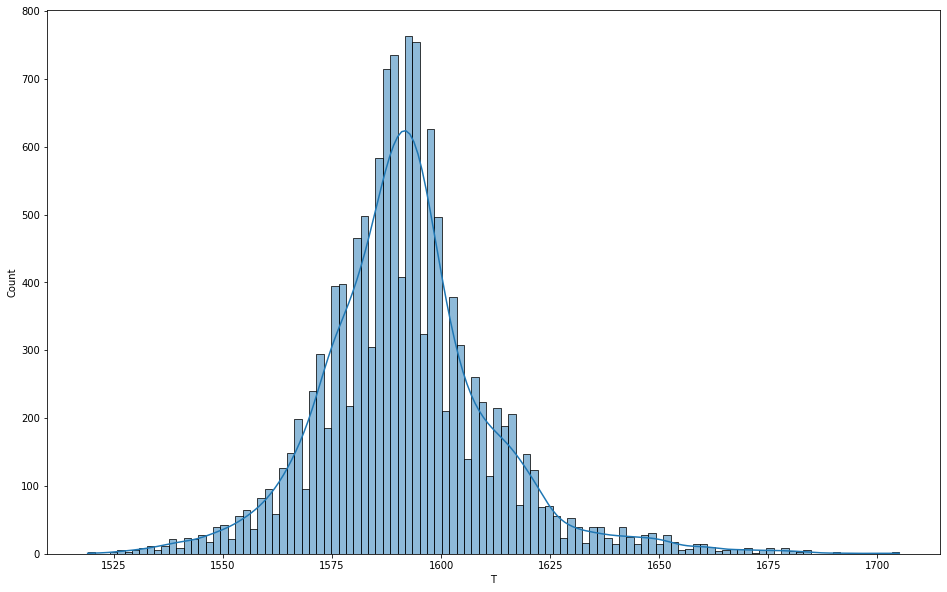

In [138]:
plt.figure(figsize=(16,10))
sns.histplot(data_temp['T'], kde=True);

## Выводы:
1. В некоторых таблицах присутствуют пропуски и выбросы, однако у них разные причины появления и соответственно разные механизмы устранения.
2. В таблицах по объёму и времени добавления добавок пропуски обуссловлены, что не все добавки используются для выплавки разных типов сталей, поэтому в таблицах объёмов пропуски можно заменить на 0. В остальных таблицах строки с пропусками важных данных следует удалить.
3. Выбросы присутствуют в том или ином виде, однако требуют тщательного изучения. Те выбросы которые нефизичны - отрицательная реактивная мощность, температура меньше 1400 нужно удалить из всего датасета, те которые возможны - стоит удалить из обработанного датасета только из тренировочного набора.
4. Некоторые операции технологического процесса и измерения проводятся для одной партии несколько раз - это необходимо учитывать при конструировании признаков.
5. Многие виды добавок используются редко - данные по ним следует исключить из датасета.

## План проекта
1. **Исследовательский анализ и исправление данных отдельных таблиц.** В качестве инструментов анализа использовать графики (гистограммы, ящик с усами, диаграммы рассеяния) и статисические методы (описательная статистика, корреляции). Затем необходимо удалить выбросы и исправить ошибки в данных.
2. **Отбор и конструирование признаков.** Для этого необходимо ввести новые переменные в отдельные таблицы. Удалить лишние на мой взгляд. Оставить только начальные и конечные значения температур. Длаее необходимо свести все данные из таблиц в отдельную таблицу и исключить строки, в которых отсутствует целевое значение. Проверить данные на мультиколинеарность. В данных нет категориальных переменных поэтому этап кодирования не нужен.
3. **Обучение моделей.** Перед обучением необходимо разделить данные на тестовую и обучающую выборки. Затем построить базовую линию. Обучить и рассмотреть методом cross-validation несколько моделей с подбором оптимальных гиперпараметров. Как минимум следует рассмотреть модели на деревьях и линейные модели. Определить лучшую модель.
4. **Тестирование лучшей модели на тестовом наборе c проверкой адекватности модели**
5. **Выводы**

На данном этапе дополнительных вопросов к заказчику не возникло с учетом вебинара.

## Отбор и конструирование признаков

### Работа с отдельными таблицами

##### Данные об электродах

In [139]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   key         14875 non-null  int64          
 1   arc_start   14875 non-null  datetime64[ns] 
 2   arc_end     14875 non-null  datetime64[ns] 
 3   p_active    14875 non-null  float64        
 4   p_reactive  14875 non-null  float64        
 5   arc_time    14875 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), timedelta64[ns](1)
memory usage: 813.5 KB


In [140]:
data_arc.head()

,key,arc_start,arc_end,p_active,p_reactive,arc_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0 days 00:02:28


Для с точки зрения физики для процесса нагревания важно произведение активной мощности на время которое равно количеству теплоты. Кроме того высокая корреляция между активной и реактивной мощностью означает что мы можем не рассматривать некоторые переменные.
На данном этапе выбираем следующие параметры:
1. Активная энергия
2. Реактивная мощность
3. Актиная мощность  
Пока сохраняем временные метки, а отрезок времени преобразуем в секунды.

In [141]:
data_arc['arc_time'] = data_arc['arc_time'].dt.seconds
data_arc['q'] = data_arc['arc_time']*data_arc['p_active']
data_arc.head()

,key,arc_start,arc_end,p_active,p_reactive,arc_time,q
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,222.541395
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,149.037310
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,128.030509
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,605.667332
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,102.527702


Далее необзодимо как то объединить данные для одной партии. Возпользуемся сводной таблицей. Посчитаем следующие параметр:
1. Суммарная, минимальная, максимальная, средняя энергия
2. Максимальная, средняя, минимальная активная можность
3. Максимальная, средняя, минимальная реактивная можность
4. Количество циклов включения дуги

In [142]:
data_arc = pd.pivot_table(data_arc[['key', 'arc_end', 'p_active', 'p_reactive', 'q']], index=['key'],
                          values=['arc_end', 'p_active', 'p_reactive', 'q'],
                          aggfunc={'arc_end':[len],
                                    'p_active':[min, max, np.mean],
                                    'p_reactive':[min, max, np.mean],
                                    'q':[min, max, np.mean, sum]})
data_arc.head()

arc_end  p_active                     p_reactive                      \
        len       max      mean       min        max      mean       min   
key                                                                        
1         5  1.659363  0.975629  0.692755   1.062669  0.636648  0.414397   
2         4  1.296415  0.763150  0.438063   0.892914  0.499528  0.283043   
3         5  1.062053  0.505176  0.250280   0.671494  0.319815  0.155901   
4         4  1.220955  0.802313  0.425692   0.754719  0.515074  0.268482   
5         4  1.621665  0.836793  0.267457   1.047776  0.563161  0.181992   

              q                                       
            max        mean         min          sum  
key                                                   
1    605.667332  241.560850  102.527702  1207.804249  
2    438.188301  183.454118   60.014678   733.816470  
3    297.374822   88.716665   16.268194   443.583327  
4    339.425494  167.665832   42.143551   670.663327  
5    672.990827  249.374024   18.989414   997.496095

In [143]:
data_arc.columns = ['n_arc', 'pa_max', 'pa_mean', 'pa_min', 'pr_max', 'pr_mean', 'pr_min',
                    'q_max', 'q_mean', 'q_min', 'q_sum']
data_arc.head()

,n_arc,pa_max,pa_mean,pa_min,pr_max,pr_mean,pr_min,q_max,q_mean,q_min,q_sum
key,,,,,,,,,,,
1,5,1.659363,0.975629,0.692755,1.062669,0.636648,0.414397,605.667332,241.560850,102.527702,1207.804249
2,4,1.296415,0.763150,0.438063,0.892914,0.499528,0.283043,438.188301,183.454118,60.014678,733.816470
3,5,1.062053,0.505176,0.250280,0.671494,0.319815,0.155901,297.374822,88.716665,16.268194,443.583327
4,4,1.220955,0.802313,0.425692,0.754719,0.515074,0.268482,339.425494,167.665832,42.143551,670.663327
5,4,1.621665,0.836793,0.267457,1.047776,0.563161,0.181992,672.990827,249.374024,18.989414,997.496095


Проверим выбросы.

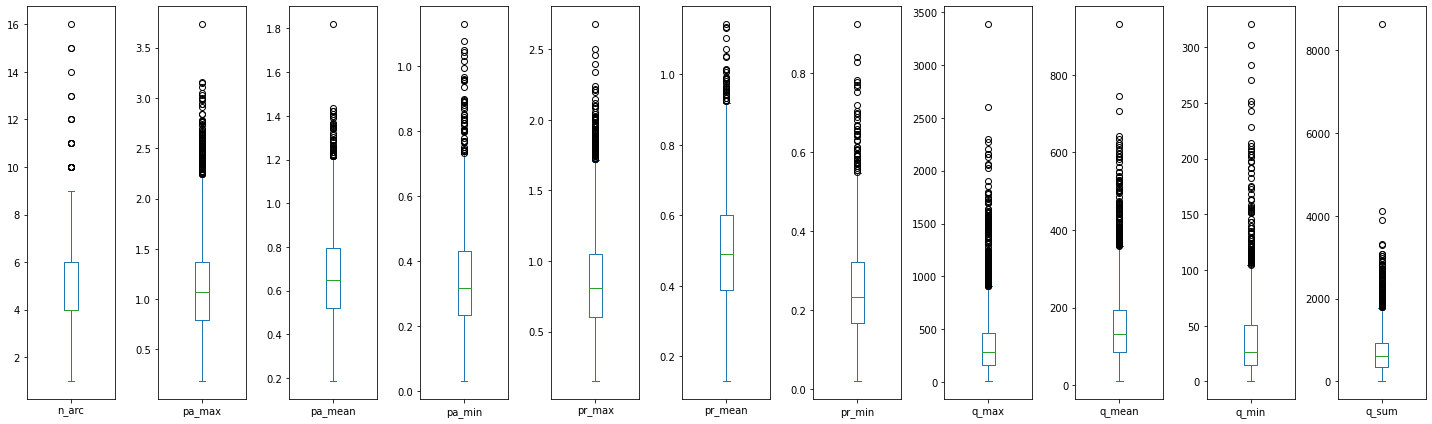

In [144]:
cols = ['n_arc', 'pa_max', 'pa_mean', 'pa_min', 'pr_max', 'pr_mean', 'pr_min', 'q_max', 'q_mean', 'q_min', 'q_sum']
fig, axs = plt.subplots(1, len(cols), figsize=(20,6))
for i, col in enumerate(cols):
    data_arc[col].plot(kind='box', ax=axs[i]);
fig.tight_layout()

Одна точка значительно выбивается особенно это видно из графика для суммарного количества теплоты. Но её будем удалять только из рабочего набора если она к тому времени ещё останется в таблице. Построим корреляционную матрицу.

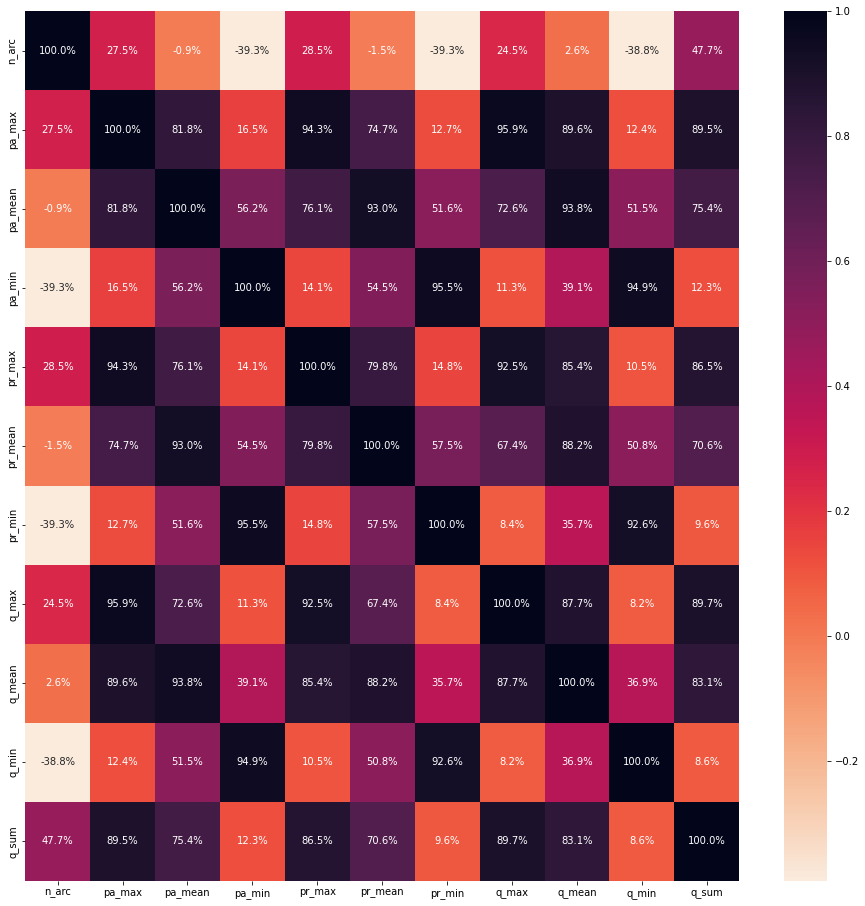

In [145]:
plt.figure(figsize = (16,16))
sns.heatmap(data_arc[cols].corr(), cmap="rocket_r", annot=True, fmt=".1%"); 

Есть сильноскоррелирванные признаки, pa_max и q_max, pa_min и q_min, pa_mean и pa_mean. Можем удалить pa_max, pa_mean, pa_min так как q в этой задаче ииеет больший физический смысл.

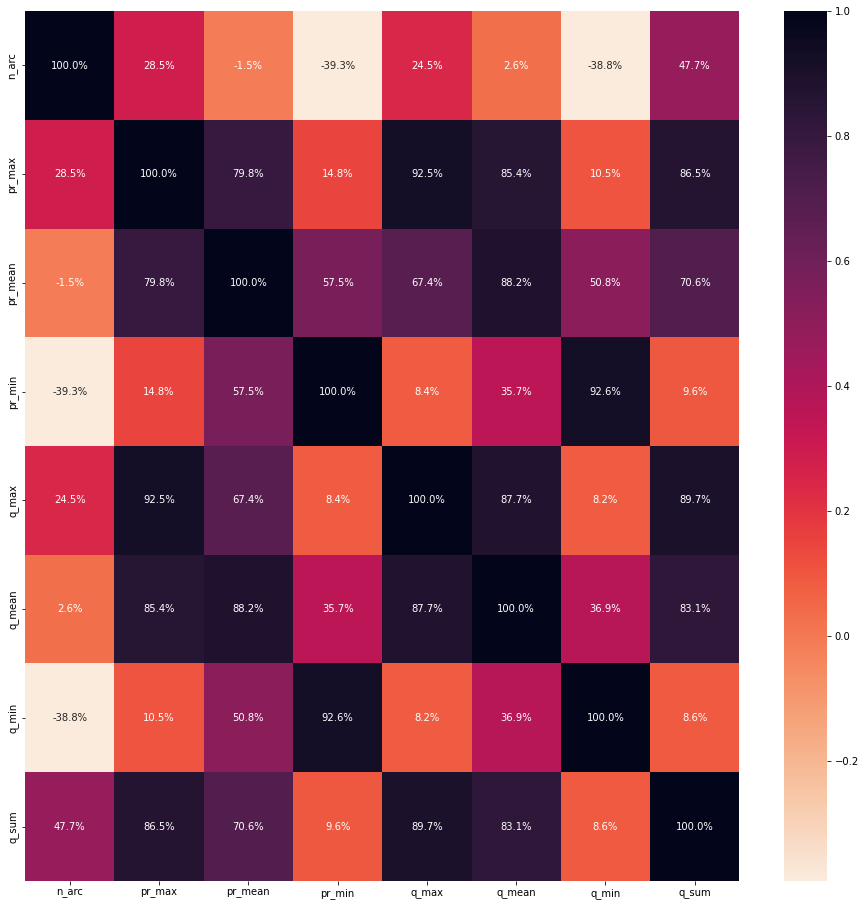

In [146]:
plt.figure(figsize = (16,16))
data_arc = data_arc.drop(columns=['pa_max', 'pa_mean', 'pa_min'])
cols.remove('pa_max')
cols.remove('pa_min')
cols.remove('pa_mean')
sns.heatmap(data_arc[cols].corr(), cmap="rocket_r", annot=True, fmt=".1%"); 

С данными по электродам поработали.

#### Данные по добавкам и газам (Объём)

Строение таблиц примерно одинаковое и их в конце можно объединить. Начнём с сыпучих основную предобработку мы сделали на предыдущем этапе. Теперь нужно удалить данные по самым редким добавкам.

In [147]:
data_bulk = data_bulk_nna.drop(columns=['Bulk 7', 'Bulk 2', 'Bulk 9', 'Bulk 13', 'Bulk 8'])
data_bulk.head()

,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0
1,2,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0
2,3,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0
3,4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0
4,5,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0


Для проволочных оставляем только 1 и 2.

In [148]:
data_wire = data_wire_nna.iloc[:, :3]
data_wire.head()

,key,Wire 1,Wire 2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


Объединяем в одну таблицу. Согласно требованию заказчика используем inner объединение.

In [149]:
data_ads = data_bulk.set_index('key').join(data_wire.set_index('key'), how='inner')
data_ads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3025 entries, 1 to 3241
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Bulk 1   3025 non-null   float64
 1   Bulk 3   3025 non-null   float64
 2   Bulk 4   3025 non-null   float64
 3   Bulk 5   3025 non-null   float64
 4   Bulk 6   3025 non-null   float64
 5   Bulk 10  3025 non-null   float64
 6   Bulk 11  3025 non-null   float64
 7   Bulk 12  3025 non-null   float64
 8   Bulk 14  3025 non-null   float64
 9   Bulk 15  3025 non-null   float64
 10  Wire 1   3025 non-null   float64
 11  Wire 2   3025 non-null   float64
dtypes: float64(12)
memory usage: 307.2 KB


Объединяем с "газовой" таблицей.

In [150]:
data_ads = data_ads.join(data_gas.set_index('key'), how='inner')
data_ads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3023 entries, 1 to 3241
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Bulk 1   3023 non-null   float64
 1   Bulk 3   3023 non-null   float64
 2   Bulk 4   3023 non-null   float64
 3   Bulk 5   3023 non-null   float64
 4   Bulk 6   3023 non-null   float64
 5   Bulk 10  3023 non-null   float64
 6   Bulk 11  3023 non-null   float64
 7   Bulk 12  3023 non-null   float64
 8   Bulk 14  3023 non-null   float64
 9   Bulk 15  3023 non-null   float64
 10  Wire 1   3023 non-null   float64
 11  Wire 2   3023 non-null   float64
 12  gas      3023 non-null   float64
dtypes: float64(13)
memory usage: 330.6 KB


In [151]:
data_ads.head()

,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,gas
key,,,,,,,,,,,,,
1,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,60.059998,0.00000,29.749986
2,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,96.052315,0.00000,12.555561
3,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,91.160157,0.00000,28.554793
4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,89.063515,0.00000,18.841219
5,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0,89.238236,9.11456,5.413692


Таблицы по времени добавления использовать затруднительно, так как в системе по утверждению заказчика отсутствует синхронизация и поэтому нет надёжной точки отсчета.

#### Данные по температуре
Самая важная таблица, так как помимо независимых переменных содержит целевую.

In [152]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12999 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     12999 non-null  int64         
 1   t_time  12999 non-null  datetime64[ns]
 2   T       12999 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.2 KB


Убираем те строки где был всего один замер.

In [153]:
data_temp_count = data_temp.groupby('key')['T'].count()
data_temp_val_keys = set(data_temp_count[data_temp_count > 1].index)

In [154]:
data_temp = data_temp.query('key in @data_temp_val_keys')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12259 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     12259 non-null  int64         
 1   t_time  12259 non-null  datetime64[ns]
 2   T       12259 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 383.1 KB


Вычисляем таблицу по начальному и конечному изменению температуры.

In [155]:
data_temp_sorted_time = data_temp.groupby(['key', 't_time'])['T'].agg(lambda x: x).reset_index()
data_temp_sorted_time.head(20)

,key,t_time,T
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [156]:
data_temp = pd.pivot_table(data_temp, index=['key'],
                          values=['t_time', 'T'],
                          aggfunc={'t_time': 'last',
                                    'T':['first', 'last']})
data_temp.columns = ['T_start', 'T_end', 'T_time_end']
data_temp = data_temp.drop('T_time_end', axis=1)
data_temp.head()

,T_start,T_end
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


### Объединение таблиц и анализ полученных данных

Данные по температуре приоритетны поэтому присоединяем всё к ним последовательно.

In [157]:
data_all = data_temp.join(data_arc, how='inner')
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   T_start  2475 non-null   float64
 1   T_end    2475 non-null   float64
 2   n_arc    2475 non-null   int64  
 3   pr_max   2475 non-null   float64
 4   pr_mean  2475 non-null   float64
 5   pr_min   2475 non-null   float64
 6   q_max    2475 non-null   float64
 7   q_mean   2475 non-null   float64
 8   q_min    2475 non-null   float64
 9   q_sum    2475 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 212.7 KB


Присоединяем таблицу по объёмам.

In [158]:
data_all = data_all.join(data_ads, how='inner')
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 23 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   T_start  2329 non-null   float64
 1   T_end    2329 non-null   float64
 2   n_arc    2329 non-null   int64  
 3   pr_max   2329 non-null   float64
 4   pr_mean  2329 non-null   float64
 5   pr_min   2329 non-null   float64
 6   q_max    2329 non-null   float64
 7   q_mean   2329 non-null   float64
 8   q_min    2329 non-null   float64
 9   q_sum    2329 non-null   float64
 10  Bulk 1   2329 non-null   float64
 11  Bulk 3   2329 non-null   float64
 12  Bulk 4   2329 non-null   float64
 13  Bulk 5   2329 non-null   float64
 14  Bulk 6   2329 non-null   float64
 15  Bulk 10  2329 non-null   float64
 16  Bulk 11  2329 non-null   float64
 17  Bulk 12  2329 non-null   float64
 18  Bulk 14  2329 non-null   float64
 19  Bulk 15  2329 non-null   float64
 20  Wire 1   2329 non-null   float64
 21  Wire 2   2329 

Проведём последние перед построением модели проверки данных.

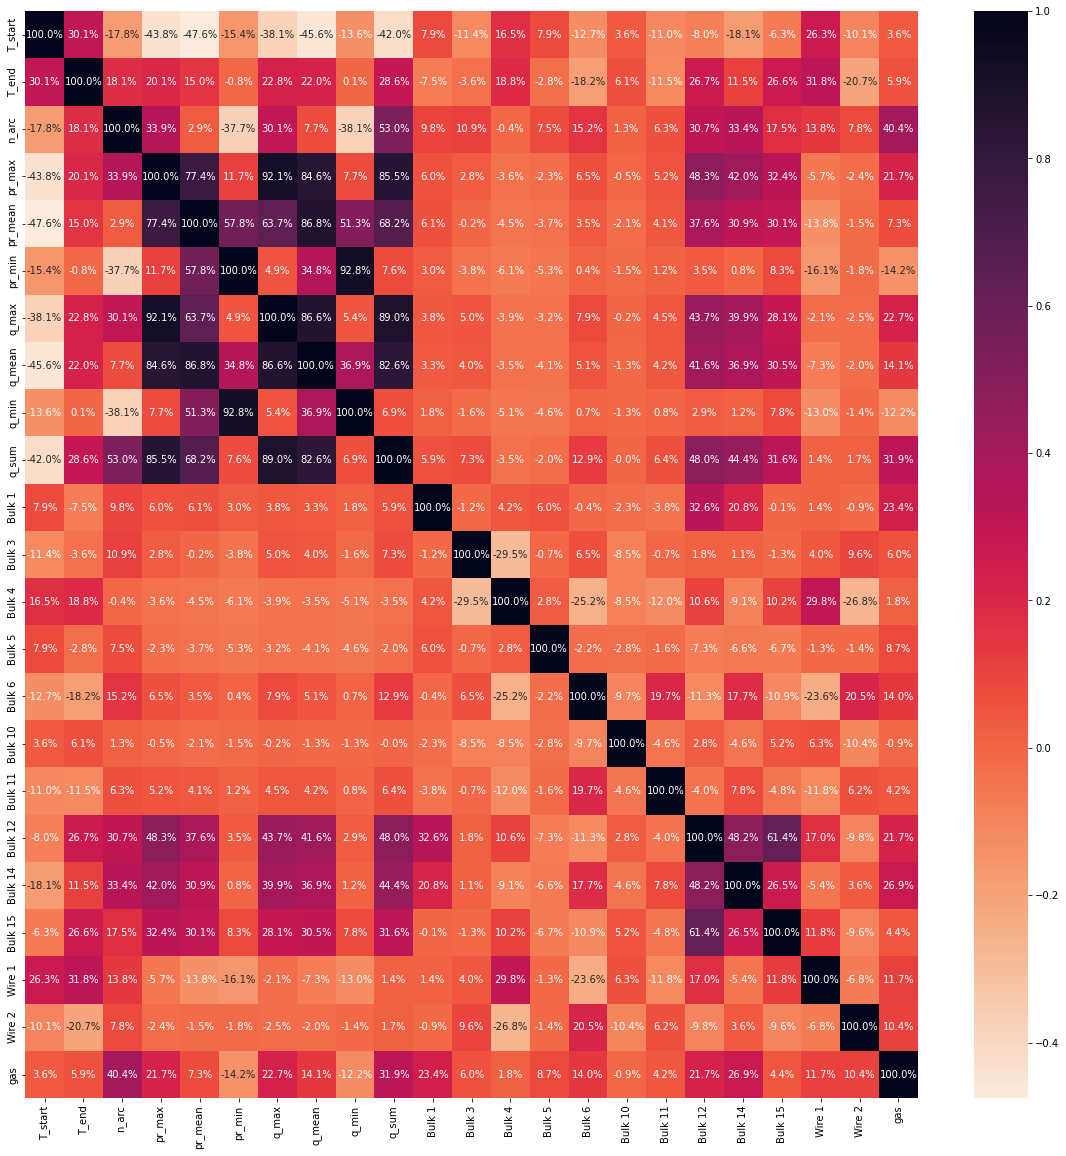

In [159]:
plt.figure(figsize = (20,20))
sns.heatmap(data_all.corr(), cmap="rocket_r", annot=True, fmt=".1%"); 

Коррелируют между собой параметры дуги, а с таргетом наиболее коррелирует начальная температура, среднее количество теплоты, объём Bulk 14. Это имеет особое значение для линейных моделей, так как решение становится неустойичвым, однако регуляризация снижает эффект от частичной мультиколлинеарностм.

Для самых скоррелированных значений построи диаграммы рассеяния.

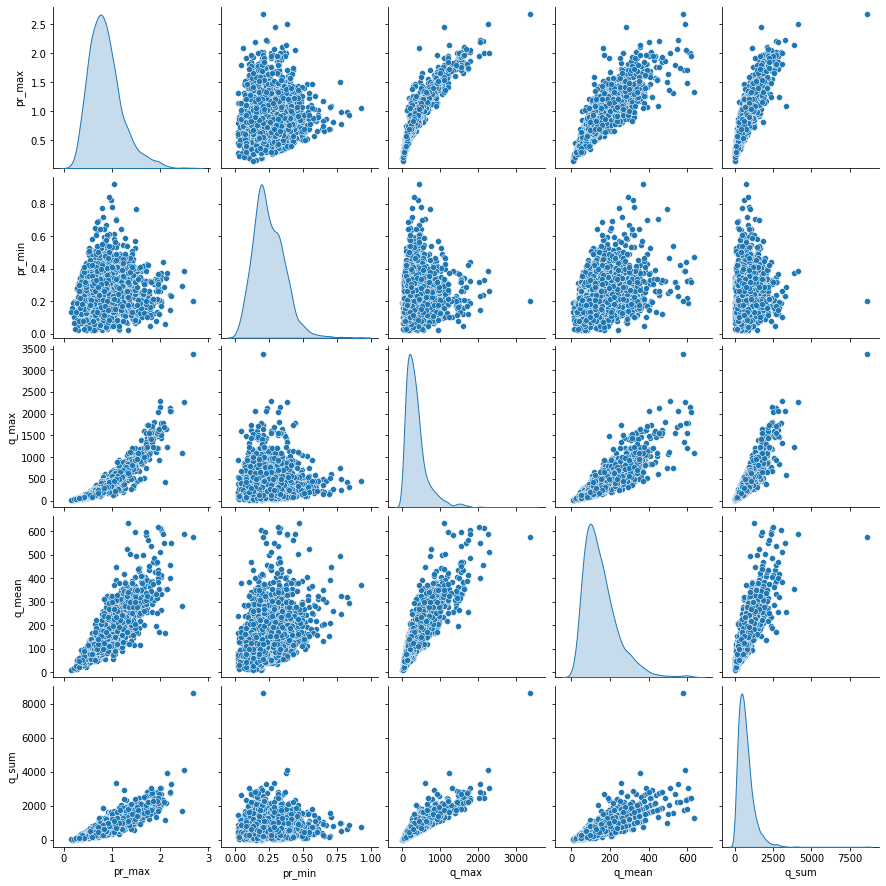

In [160]:
strong_corr = ["pr_max","pr_min", "q_max", "q_mean", "q_sum"]
sns.pairplot(data_all[strong_corr], diag_kind='kde');

Некоторые связи носят нелинейных характер. Так же заметны точки которые выбивается из графика.

## Обучение моделей

В качестве моделей возьмём гребневую регрессию, метод опорных векторов и ансамблевый метод градиентного бустинга. Последнюю модель возьмём из библиотеки LightGBM. Первые две модели требуют стандартизации переменных, а последняя может работать без этого шага.

### Разделение выборок

In [161]:
X = data_all.drop("T_end", axis=1)
y = data_all.T_end
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

Проверим не попали ли в обучающую выборку аномальные точки.

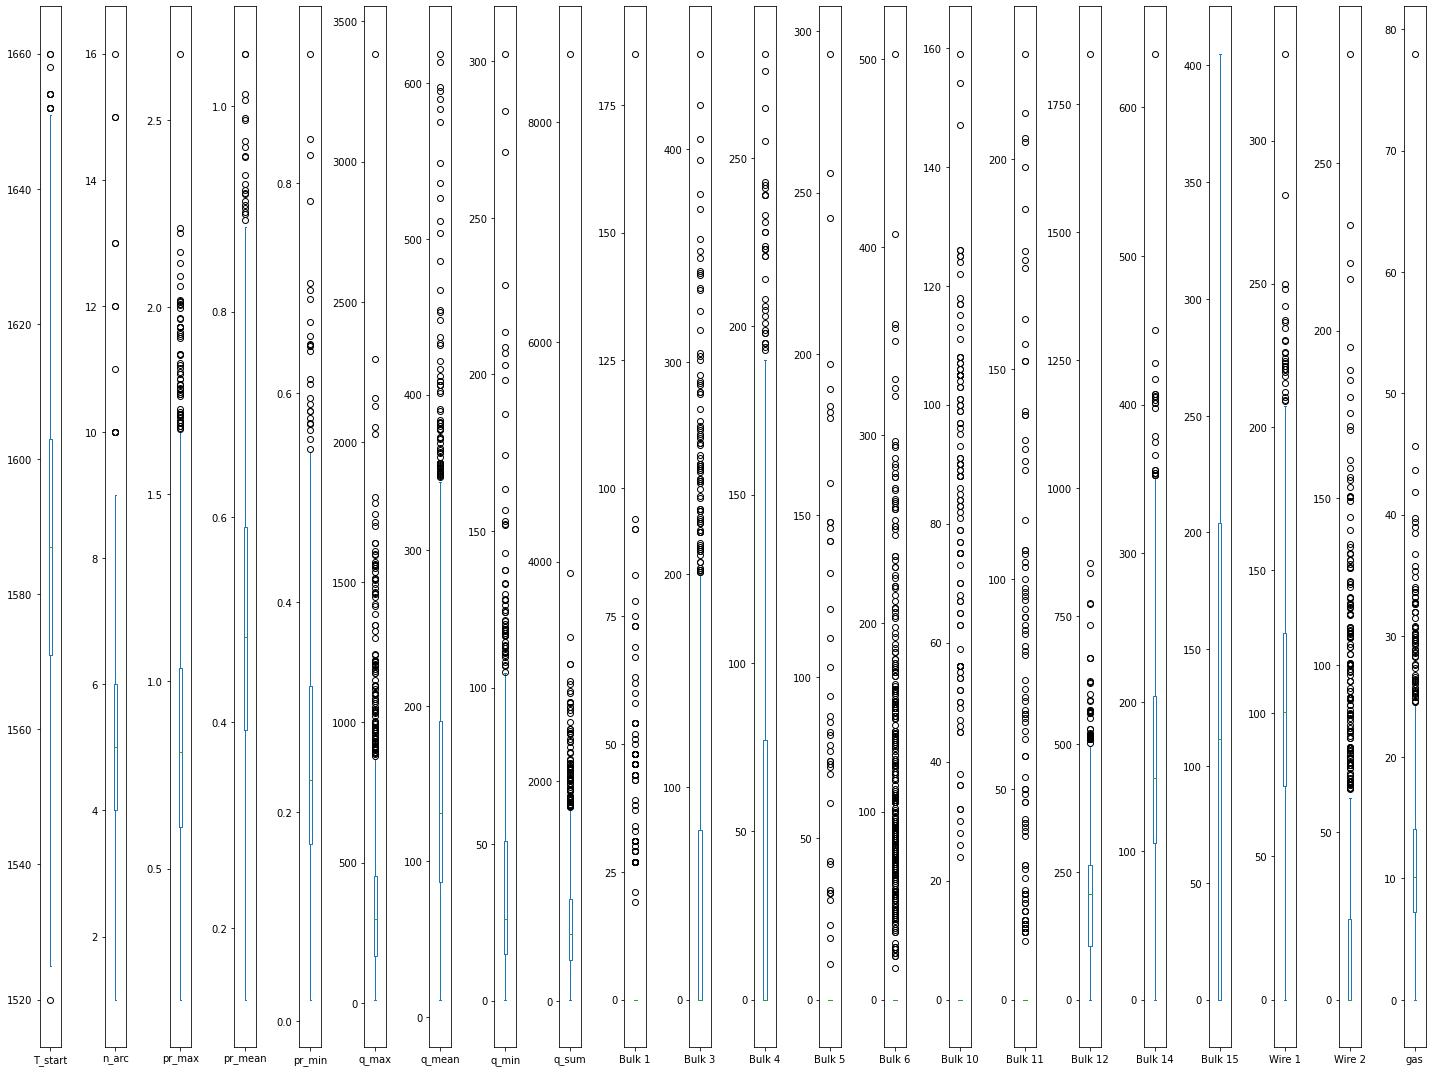

In [162]:
cols = X_train.columns
fig, axs = plt.subplots(1, len(cols), figsize=(20,15))
for i, col in enumerate(cols):
    X_train[col].plot(kind='box', ax=axs[i]);
fig.tight_layout()

Попали некоторые нетипичные точки попробуем их удалить не сильно урезав выборку.

In [164]:
Xy_train = X_train.join(y_train)
Xy_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 936 to 1175
Data columns (total 23 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   T_start  1746 non-null   float64
 1   n_arc    1746 non-null   int64  
 2   pr_max   1746 non-null   float64
 3   pr_mean  1746 non-null   float64
 4   pr_min   1746 non-null   float64
 5   q_max    1746 non-null   float64
 6   q_mean   1746 non-null   float64
 7   q_min    1746 non-null   float64
 8   q_sum    1746 non-null   float64
 9   Bulk 1   1746 non-null   float64
 10  Bulk 3   1746 non-null   float64
 11  Bulk 4   1746 non-null   float64
 12  Bulk 5   1746 non-null   float64
 13  Bulk 6   1746 non-null   float64
 14  Bulk 10  1746 non-null   float64
 15  Bulk 11  1746 non-null   float64
 16  Bulk 12  1746 non-null   float64
 17  Bulk 14  1746 non-null   float64
 18  Bulk 15  1746 non-null   float64
 19  Wire 1   1746 non-null   float64
 20  Wire 2   1746 non-null   float64
 21  gas      174

In [165]:
Xy_train = Xy_train[(Xy_train['pr_max'] < 2.5) & (Xy_train['Bulk 1'] < 100) & \
                    (Xy_train['q_sum'] < 4000) & (Xy_train['Bulk 12'] < 1000) & (Xy_train['gas'] < 50)]
Xy_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1744 entries, 936 to 1175
Data columns (total 23 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   T_start  1744 non-null   float64
 1   n_arc    1744 non-null   int64  
 2   pr_max   1744 non-null   float64
 3   pr_mean  1744 non-null   float64
 4   pr_min   1744 non-null   float64
 5   q_max    1744 non-null   float64
 6   q_mean   1744 non-null   float64
 7   q_min    1744 non-null   float64
 8   q_sum    1744 non-null   float64
 9   Bulk 1   1744 non-null   float64
 10  Bulk 3   1744 non-null   float64
 11  Bulk 4   1744 non-null   float64
 12  Bulk 5   1744 non-null   float64
 13  Bulk 6   1744 non-null   float64
 14  Bulk 10  1744 non-null   float64
 15  Bulk 11  1744 non-null   float64
 16  Bulk 12  1744 non-null   float64
 17  Bulk 14  1744 non-null   float64
 18  Bulk 15  1744 non-null   float64
 19  Wire 1   1744 non-null   float64
 20  Wire 2   1744 non-null   float64
 21  gas      174

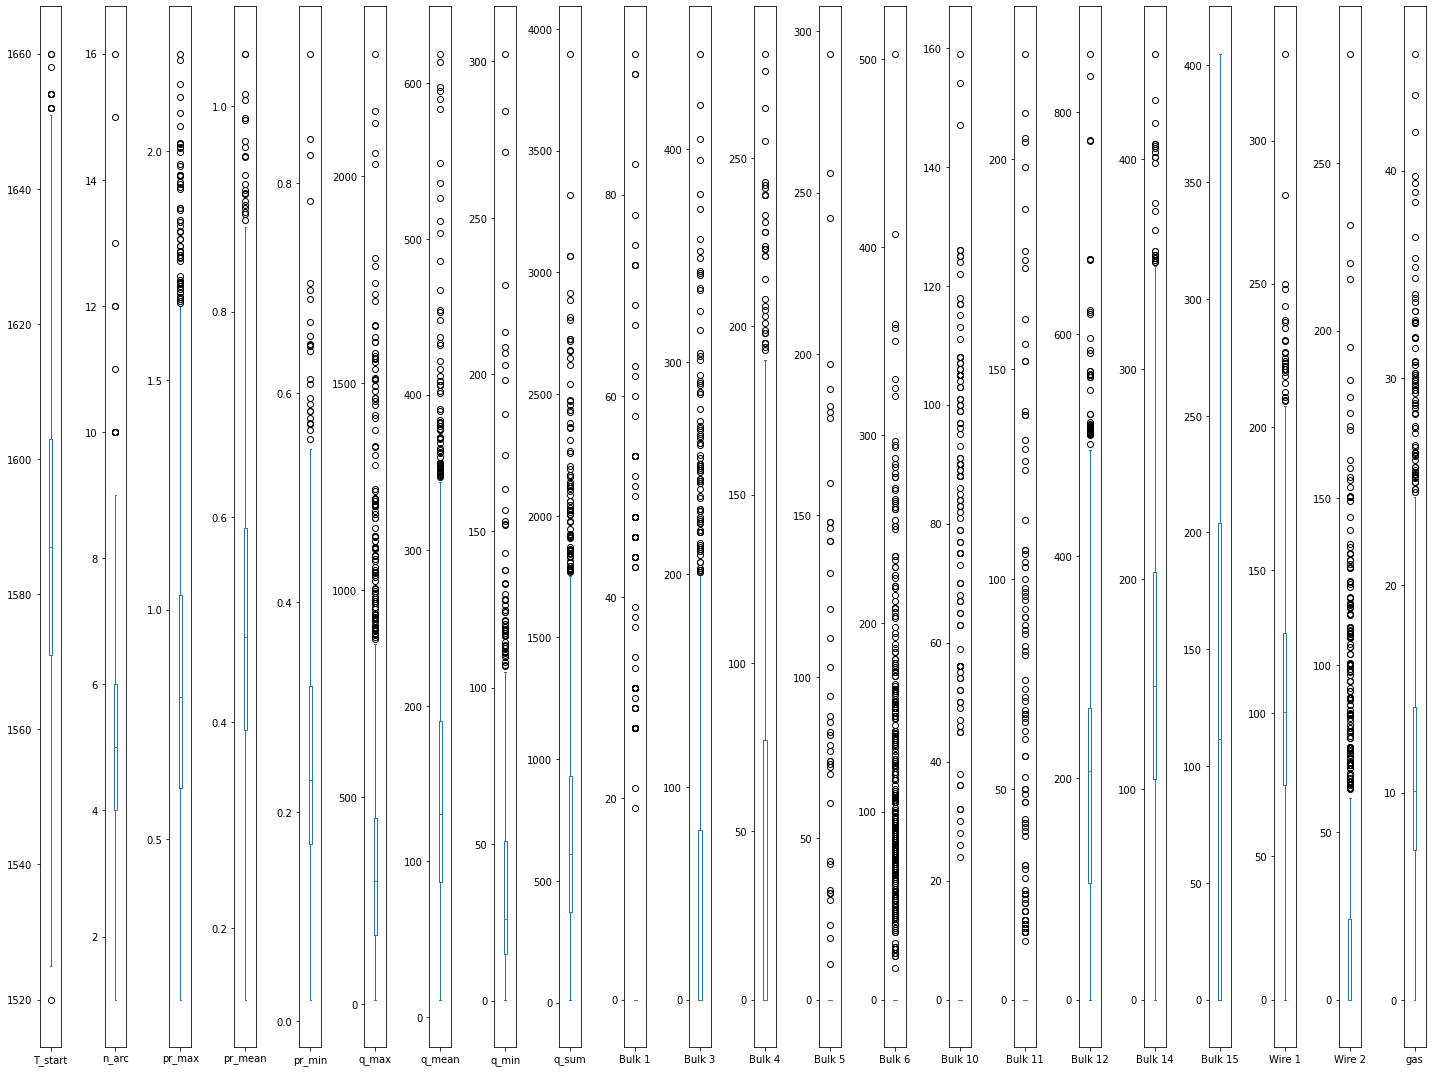

In [166]:
cols = X_train.columns
fig, axs = plt.subplots(1, len(cols), figsize=(20,15))
for i, col in enumerate(cols):
    Xy_train[col].plot(kind='box', ax=axs[i]);
fig.tight_layout()

Экстемальных выбросов в обучающей выборки стало меньше и мы потеряли мало точек.

In [167]:
X_train = Xy_train.drop(columns=['T_end'])
y_train = Xy_train['T_end']

### Модели

#### Базовая линия
В качестве dummy-модели для метрики MAE лучше использовать стратегию медианного значения. 

In [168]:
scorer = 'neg_mean_absolute_error'
dummy = DummyRegressor(strategy='median')
dummy_mae = abs(cross_val_score(dummy, X_train, y_train, scoring=scorer).mean())
print(f"MAE (CV) for dummy model = {dummy_mae:.3}")

MAE (CV) for dummy model = 8.07


8 градусов.

#### Гребневая регрессия
Один важный гиперпараметр будем перебирать - степень регуляризации. Воспользуемся Pipline и GridSearchCV.

In [169]:
ridge = Ridge(random_state=RANDOM_STATE)
pipe = Pipeline([("scalar", StandardScaler()), ("ridge", ridge)])
params = {"ridge__alpha":np.logspace(-5, 5, 20)}
gscv_ridge = GridSearchCV(pipe, params, scoring=scorer, verbose=3, n_jobs=-1)

In [170]:
gscv_ridge.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('ridge', Ridge(random_state=130323))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])},
             scoring='neg_mean_absolute_error', verbose=3)

In [171]:
best_ridge_cv_mae = abs(gscv_ridge.best_score_)
best_ridge_alpha = gscv_ridge.best_params_["ridge__alpha"]
best_ridge = gscv_ridge.best_estimator_
print(f"MAE (cv) for best ridge model = {best_ridge_cv_mae:.3f} for Alpha = {best_ridge_alpha}")

MAE (cv) for best ridge model = 6.289 for Alpha = 20.6913808111479


Уже неплохо.

#### Метод опорных векторов

Используем разные ядра (линейная функция, полином, радиально-базисная функция, сигмоида). Будем также подбирать параметр регуляризации (С) и epsilon, который определяет зону нечувствительности.

In [172]:
svr = SVR(max_iter=100000)

pipe = Pipeline([("scalar", StandardScaler()), ("svr", svr)])
params = {"svr__C": np.logspace(-3, 3, 10),
          "svr__epsilon":[0.1, 0.5, 1.0, 2.5, 5],
         'svr__kernel':['linear', 'poly', 'rbf', 'sigmoid']}
gscv_svr = GridSearchCV(pipe, params, scoring=scorer, verbose=3, n_jobs=-1)

In [173]:
gscv_svr.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('svr', SVR(max_iter=100000))]),
             n_jobs=-1,
             param_grid={'svr__C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'svr__epsilon': [0.1, 0.5, 1.0, 2.5, 5],
                         'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_absolute_error', verbose=3)

In [176]:
best_svr_cv_mae = abs(gscv_svr.best_score_)
best_svr_c = gscv_svr.best_params_["svr__C"]
best_svr_eps = gscv_svr.best_params_["svr__epsilon"]
best_svr_kernel = gscv_svr.best_params_["svr__kernel"]
best_svr = gscv_svr.best_estimator_
print(f"MAE (cv) for best svr model = {best_svr_cv_mae:.3f} for C = {best_svr_c}, epsilon={best_svr_eps}  and {best_svr_kernel} kernel")

MAE (cv) for best svr model = 6.168 for C = 10.0, epsilon=1.0  and rbf kernel


Лучше, чем на гребневой регрессии при использовании радиально-базисной функции в качестве нелинейного ядра.

#### Градиентный бустинг решающих деревьев

Воспользуемся LigthGBM. Будем перебирать количество листьев и скорость обучения.

In [177]:
gb = LGBMRegressor(random_state=RANDOM_STATE, n_estimators=100)
params = {"num_leaves":[10, 15, 20, 25, 30, 40, 50], 'learning_rate':[0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0]}
gscv_gb = GridSearchCV(gb, params, scoring=scorer, verbose=3, n_jobs=-1)

In [178]:
gscv_gb.fit(X_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(estimator=LGBMRegressor(random_state=130323), n_jobs=-1,
             param_grid={'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2, 0.5,
                                           1.0],
                         'num_leaves': [10, 15, 20, 25, 30, 40, 50]},
             scoring='neg_mean_absolute_error', verbose=3)

In [179]:
best_gb_cv_mae = abs(gscv_gb.best_score_)
best_gb_nl = gscv_gb.best_params_["num_leaves"]
best_gb_lr = gscv_gb.best_params_["learning_rate"]
best_gb = gscv_gb.best_estimator_
print(f"MAE (cv) for best GB model = {best_gb_cv_mae:.3f} for No. leaves = {best_gb_nl}, Learning Rate = {best_gb_lr}")

MAE (cv) for best GB model = 6.059 for No. leaves = 15, Learning Rate = 0.05


Пока это лучшая модель при кросс-валидации.

#### Сравнение моделей

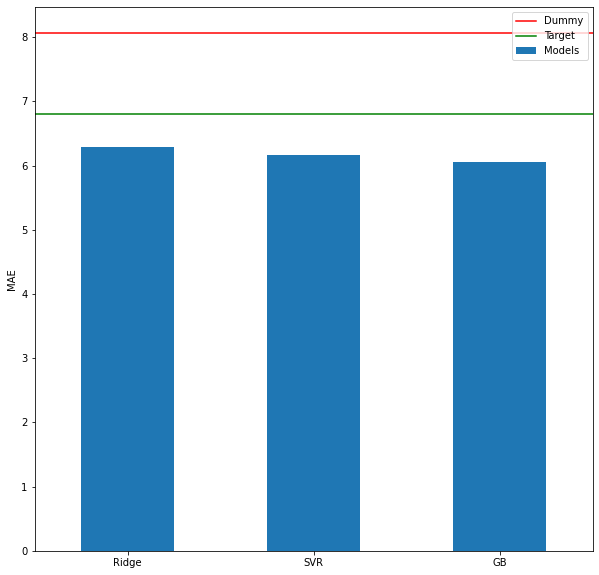

In [180]:
cv_result = pd.Series(data=[best_ridge_cv_mae, best_svr_cv_mae, best_gb_cv_mae], index=["Ridge", "SVR", "GB"], name="Models")
fig, ax = plt.subplots(1, 1,figsize=(10, 10));
ax.set_ylabel("MAE")
cv_result.plot.bar(ax=ax, rot=0);

ax.axhline(dummy_mae, c="r", label="Dummy");
ax.axhline(6.8, c="g", label="Target");
ax.legend();

Самая худшая модель - гребневая регрессия, самая лучшая - градиентный бустинг. Однако при CV все модели преодолели порог.

## Тестирование лучшей модели

### Расчет целевой метрики на тестовом наборе

In [181]:
y_pred = best_gb.predict(X_test)
gb_test_mae = mean_absolute_error(y_test, y_pred)
print(f"MAE (test) for GB model = {gb_test_mae:.3f}")

MAE (test) for GB model = 5.963


Целевой показатель достигнут.

### Проверка адекватности модели
"Обучим" тренировочном наборе Dummy модель и проверим на тестовом.

In [182]:
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
d_test_mae = mean_absolute_error(y_test, y_pred)
print(f"MAE (test) for Dummy model = {d_test_mae:.3f}")

MAE (test) for Dummy model = 7.966


Лучшая модель даёт более низкий MAE, чем Dummy.

### Анализ значимости признаков по лучшей модели

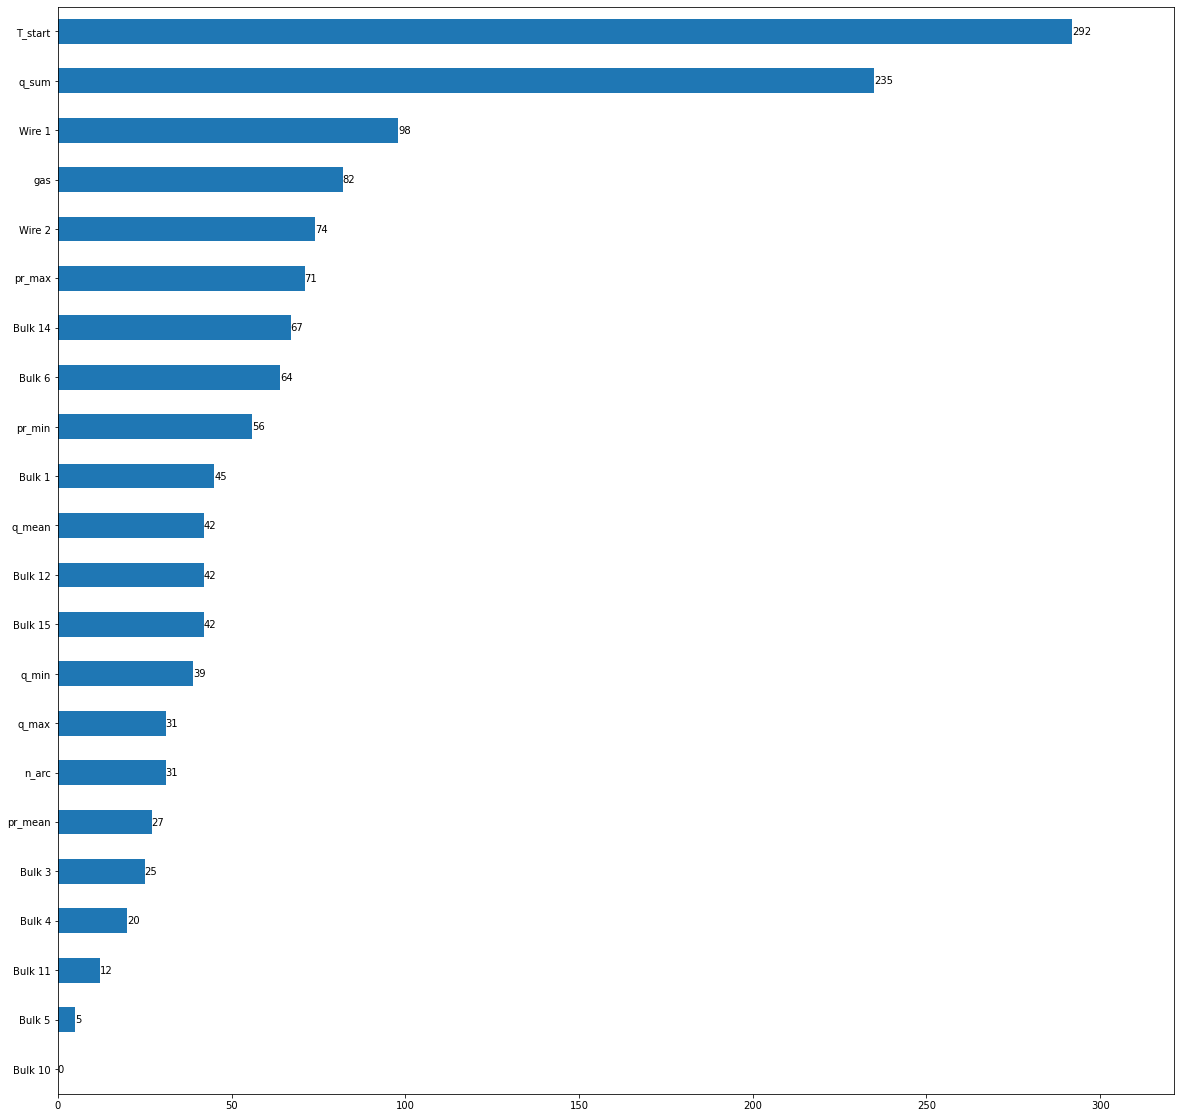

In [183]:
features = pd.Series(best_gb.feature_importances_, index=X_train.columns)
ax = features.sort_values().plot.barh(figsize=(20, 20));
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(x=0.1);

Самые важные факторы: начальная температура, общая активная энергия (теплота), Объём добавки Wire 1, газа.

## Выводы

1. Данные предобработаны. Созданы дополнительные переменные, вычленены из данных значимые.
2. Набор разбит на 2 части: тестовую и тренировочную.
3. Опробованы модели гребневой регрессии, метода опорных векторов и градиентного бустинга рещающих деревьев.
4. Для всех моделей подобраны оптимальные наиболее значимые гиперпараметры.
5. Выбор лучшей модели осуществлён при помощи метода кросс валидации. Лучшей моделью признана модель градиентного бустинга. Немного отстаёт метод опорных векторов с ядрои RBF.
6. Лучшая модель проверена на тестовом наборе. Требуемое заказчиком значение метрики MAE достигнуто.
7. Модель адекватна.
8. Самые важные факторы влияющие на конечную температуру: начальная температура, общая активная энергия (теплота), Объём добавки Wire 1, газа и Bulk 14.

## Финальный отчёт  
1. Данные, предоставленные заказчиком, были предварительно исследованы и обработаны. В некоторых таблицах присутствовали пропуски и выбросы, однако у них разные причины появления и соответственно разные механизмы устранения. В таблицах по объёму и времени добавления добавок пропуски обусловлены тем, что не все добавки используются для выплавки разных типов сталей, поэтому в таблицах объёмов пропуски были заменены на 0. В остальных таблицах строки с пропусками данных удалены.
2. Выбросы присутствовали в датасете, однако потребовалось их тщательное изучение. Те выбросы которые нефизичны - отрицательная реактивная мощность (1 значения), температура меньше 1400 (3 значения) удалены из всего датасета, те которые принципиально возможны - удалены только из тренировочного набора, после разделения дастасета на выборки, ими являлись реактивная мощность больше 2.5, нетипично высокие объёмы газа и сыпучих добавок (1 и 12).
3. Ввиду асинхронности процессов, временные метки имеет были использованы фактически только для определения начальной и конечной температур стали. В тоже время некоторые части датасета с временем добавления добавок задействовать не удалось.
4. Созданы дополнительные переменные:
  - Суммарная, минимальная, максимальная, средняя энергия, как произведение времени на активную мощность
  - Максимальная, средняя, минимальная активная можность
  - Максимальная, средняя, минимальная реактивная можность
  - Количество циклов включения дуги  
  вычленены из данных значимые признаки. Многие виды добавок используются редко - данные по ним исключены из датасета. В качестве физически значимых параметров были добавлены средняя, минимальная, максимальная и суммарная активная (тепловая) энергия. В тоже время при проверке корреляционной матрицы были исключены активные мощности и макимальная реактивная мощность.
5. Данные были объединены в одну таблицу, используя внутренее объединение по признаку "key", в соответствии с требованием заказчика. В итоговой таблице было 2239 строки, 1 таргет (конечная температура) и 22 независимых переменных:
  - стартовая температура;
  - число включений дуги;
  - cуммарная, минимальная, максимальная, средняя энергия (активная) по циклам запуска дуги;
  - средняя и минимальная реактивная мощность;
  - объём газа;
  - объёмы проволочных добавок 1 и 2;
  - объёмы сыпучих добавок 14, 6, 1, 12, 15, 3, 4, 11, 5, 10
6. Набор был разбит на 2 части: тестовую и тренировочную в соотношении 1:3.
7. Опробованы модели гребневой регрессии, метода опорных векторов и градиентного бустинга рещающих деревьев из пакета LigthGBM. Для всех моделей подобраны оптимальные наиболее значимые гиперпараметры. Выбор лучшей модели осуществлён при помощи метода кросс-валидации. Перед обученим независимые переменные были стандартизированы для моделей линейной регрессии и SVM.  
8. Лучшей моделью по метрики MAE признана модель градиентного бустинга решающих деревьев при следующих гиперпараметрах: No. leaves = 15, Learning Rate = 0.05. Значение MAE = 6.059 при кросс-валидации. Немного отстаёт метод опорных векторов с ядрои RBF и гиперпараметрами  C = 10.0, epsilon = 1.0.
9. Лучшая модель проверена на тестовом наборе. Требуемое заказчиком значение метрики MAE достигнуто и составило 5.96. Модель адекватна в сравнении с Dummy моделью.
10. Самые важные факторы влияющие на конечную температуру (в скобках указаны коэффициенты знчимости посчитанные на модели градиентного бустинга): начальная температура (292), общая активная энергия (235), объёмы добавки Wire 1 (98) и газа (82).
11. Все пункты плана выполнены успешно.